In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import math
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns#plotting purposes
from sklearn.preprocessing import LabelEncoder,OneHotEncoder# encoding purposes
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from xgboost import plot_importance
from sklearn.neural_network import MLPClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


In [2]:
sample_submission=pd.read_csv("/kaggle/input/playground-series-s3e17/sample_submission.csv")
training_set=pd.read_csv("/kaggle/input/playground-series-s3e17/train.csv")
testing_set=pd.read_csv("/kaggle/input/playground-series-s3e17/test.csv")

In [3]:
print("sample_submission", sample_submission.columns)
print("training_set", training_set.columns)
print("testing_set", testing_set.columns)

sample_submission Index(['id', 'Machine failure'], dtype='object')
training_set Index(['id', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')
testing_set Index(['id', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')


In [4]:
print("training_set shape", training_set.shape)
print("testing_set shape", testing_set.shape)

training_set shape (136429, 14)
testing_set shape (90954, 13)


# **Data Prep**

In [5]:
oversample = SMOTE()
training_set.head(10)

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
5,5,M24300,M,298.4,308.9,1429,42.1,65,0,0,0,0,0,0
6,6,L56736,L,299.6,311.0,1413,42.9,156,0,0,0,0,0,0
7,7,L55488,L,298.7,310.1,1609,38.1,67,0,0,0,0,0,0
8,8,L56397,L,297.7,308.8,1578,35.2,13,0,0,0,0,0,0
9,9,L55067,L,300.5,312.3,1447,53.3,98,0,0,0,0,0,0


In [6]:
training_set.columns = ['id', 'Product ID', 'Type', 'Air temperature',
       'Process temperature', 'Rotational speed', 'Torque',
       'Tool wear', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF']


In [7]:
training_set.tail(10)

,id,Product ID,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
136419,136419,M21064,M,300.9,310.9,1523,41.4,111,0,0,0,0,0,0
136420,136420,L56888,L,299.0,310.1,1370,50.9,84,0,0,0,0,0,0
136421,136421,L56507,L,298.5,309.2,1504,33.7,18,0,0,0,0,0,0
136422,136422,L51411,L,302.2,310.8,1515,42.9,54,0,0,0,0,0,0
136423,136423,M17346,M,298.9,308.6,1375,57.5,177,0,0,0,0,0,0
136424,136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0
136427,136427,L53876,L,301.7,310.9,1447,46.3,42,0,0,0,0,0,0
136428,136428,L47937,L,296.9,308.1,1557,39.3,229,0,0,0,0,0,0


In [8]:
training_set.shape

(136429, 14)

In [9]:
training_set.isna().sum()
training_set = training_set.dropna()

In [10]:
training_set.columns

Index(['id', 'Product ID', 'Type', 'Air temperature', 'Process temperature',
       'Rotational speed', 'Torque', 'Tool wear', 'Machine failure', 'TWF',
       'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [11]:
training_set.skew()

/tmp/ipykernel_20/906436005.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  training_set.skew()


id                      0.000000
Air temperature         0.161175
Process temperature     0.057088
Rotational speed        1.888250
Torque                 -0.028963
Tool wear              -0.027310
Machine failure         7.780216
TWF                    25.309063
HDF                    13.813058
PWF                    20.352532
OSF                    15.800499
RNF                    20.975301
dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


1.8882503109110036


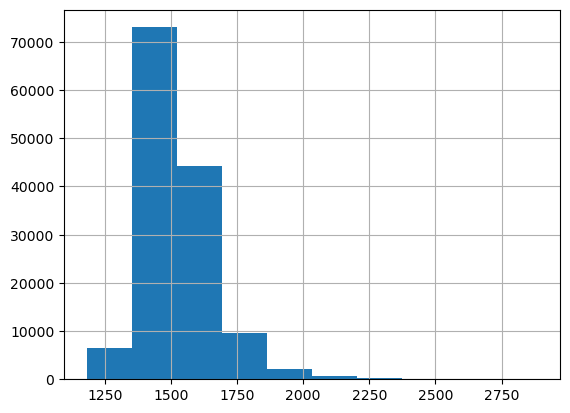

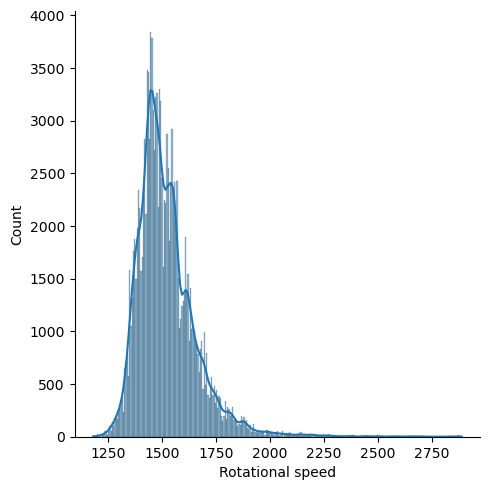

In [12]:
training_set['Rotational speed'].hist()
sns.displot(training_set, x="Rotational speed", kde=True)
print(training_set['Rotational speed'].skew()) #skewness value should be within the range of -1 to 1 for a normal distribution

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


1.2461065682787877


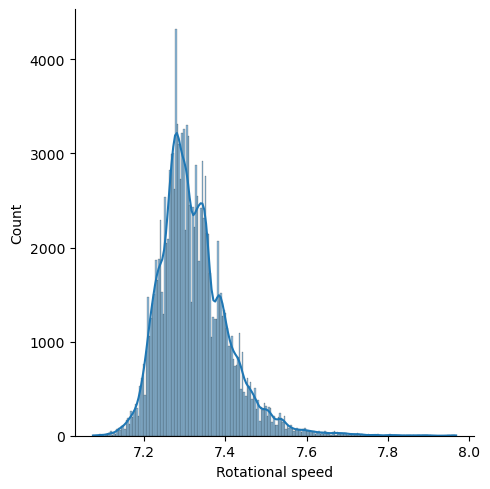

In [13]:
training_set['Rotational speed']=np.log(training_set['Rotational speed'])
sns.displot(training_set, x="Rotational speed", kde=True)
print(training_set['Rotational speed'].skew()) #skewness value should be within the range of -1 to 1 for a normal distribution

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


-0.028963391079620402


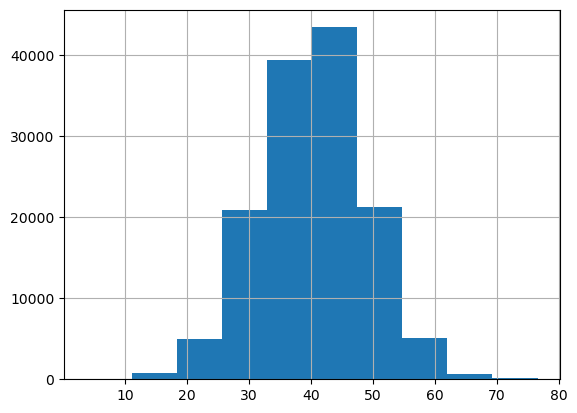

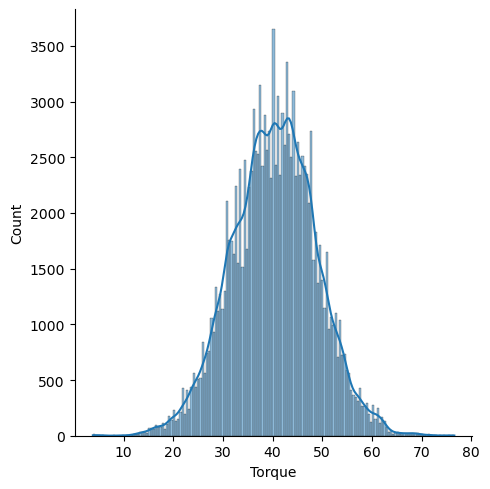

In [14]:
training_set['Torque'].hist()
sns.displot(training_set, x="Torque", kde=True)
print(training_set['Torque'].skew())

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


25.30906281340204


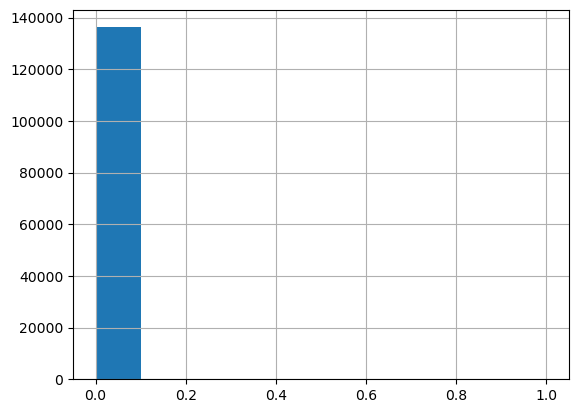

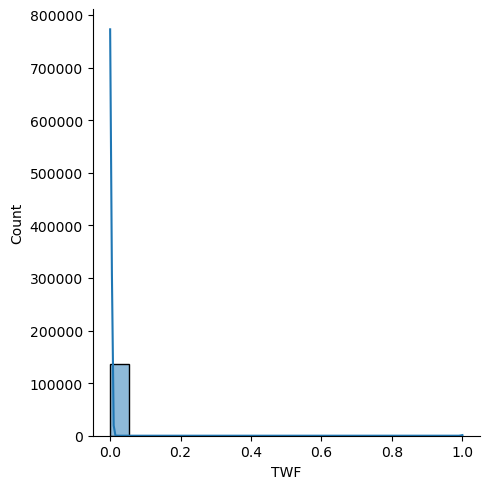

In [15]:
training_set['TWF'].hist()
sns.displot(training_set, x="TWF", kde=True)
print(training_set['TWF'].skew())

In [16]:
training_set['TWF'].unique()

array([0, 1])

## **Encoding Categorical Data**

In [17]:
training_set.dtypes

id                       int64
Product ID              object
Type                    object
Air temperature        float64
Process temperature    float64
Rotational speed       float64
Torque                 float64
Tool wear                int64
Machine failure          int64
TWF                      int64
HDF                      int64
PWF                      int64
OSF                      int64
RNF                      int64
dtype: object

In [18]:
categorical_column=['Type']
# label_encoder object
label_encoder =LabelEncoder()
# Encode labels in column. 

for i in categorical_column:
  print(i)
  training_set[i]= label_encoder.fit_transform(training_set[i])


Type


In [19]:
training_set.head()

,id,Product ID,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,1,300.6,309.6,7.375256,36.1,140,0,0,0,0,0,0
1,1,M20343,2,302.6,312.1,7.472501,29.1,200,0,0,0,0,0,0
2,2,L49454,1,299.3,308.5,7.498316,26.5,25,0,0,0,0,0,0
3,3,L53355,1,301.0,310.9,7.329094,44.3,197,0,0,0,0,0,0
4,4,M24050,2,298.0,309.0,7.403061,35.4,34,0,0,0,0,0,0


<Axes: >

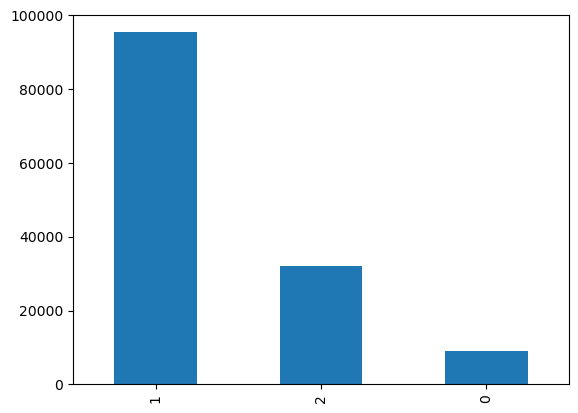

In [20]:
training_set['Type'].value_counts().plot(kind='bar')

<Axes: >

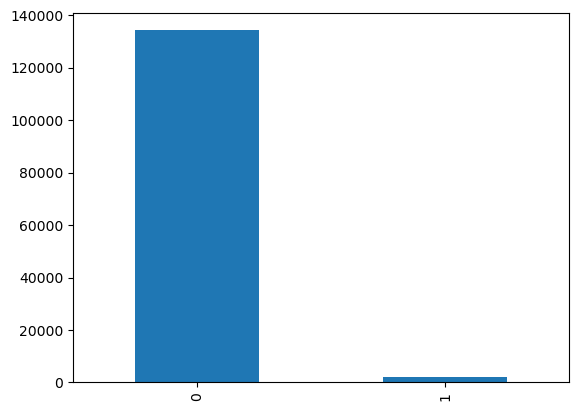

In [21]:
training_set['Machine failure'].value_counts().plot(kind='bar')

<Axes: >

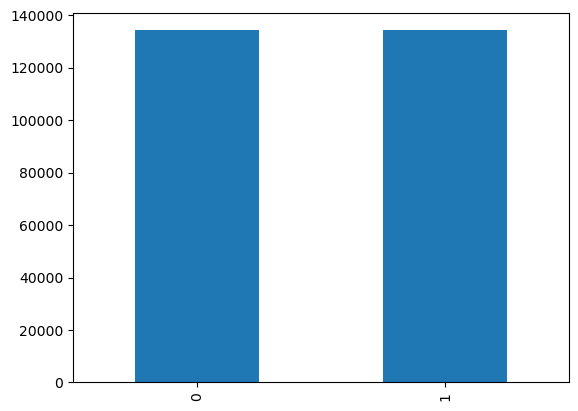

In [22]:
X = training_set.drop(columns=['Machine failure','Product ID','id'])
y = training_set['Machine failure']
X, y = oversample.fit_resample(X, y)
y.value_counts().plot(kind='bar')

In [23]:
X.dtypes
y.dtypes

dtype('int64')

Feature Importances :  [0.04799345 0.05305423 0.06981633 0.14559057 0.05057284 0.04931768
 0.11010493 0.14296594 0.19323866 0.12158034 0.01576494]


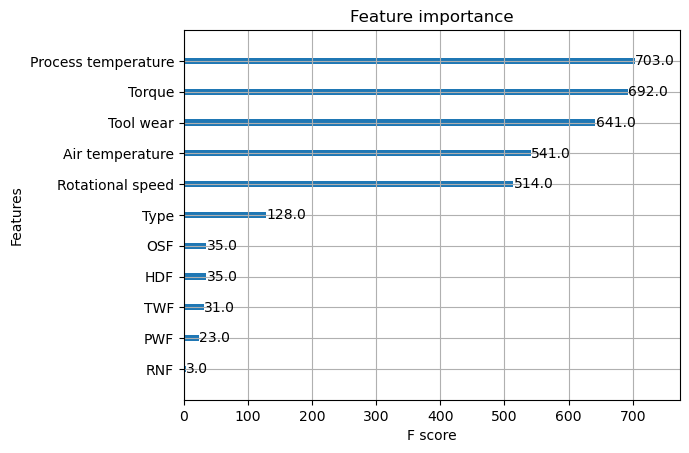

In [24]:
# fit model to training data
xgb_model = XGBClassifier(random_state = 0 )
xgb_model.fit(X, y)

print("Feature Importances : ", xgb_model.feature_importances_)

# plot feature importance
plot_importance(xgb_model)
plt.show()

# **Model Benchmarking**

In [25]:
################# Splitting into Train -Test Data #######

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,stratify =y,random_state =42)

In [26]:
X_test.head()

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,TWF,HDF,PWF,OSF,RNF
2617,1,297.5,308.4,7.395722,31.0,45,0,0,0,0,0
65312,2,301.5,311.0,7.341484,37.2,59,0,0,0,0,0
213927,1,297.2,307.9,7.191384,75.4,172,0,0,1,0,0
216183,1,298.6,309.8,7.727976,16.2,218,0,0,0,0,0
101301,1,297.1,308.3,7.305188,41.5,139,0,0,0,0,0


In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(241705, 11)
(26857, 11)
(241705,)
(26857,)


In [28]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_test)
print("Training Data Set Accuracy: ", accuracy_score(y_test,y_pred))
print("Training Data F1 Score ", f1_score(y_test,y_pred))

print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Training Data Set Accuracy:  0.9733402837249134
Training Data F1 Score  0.973469690232696
Test Accuracy:  0.9733402837249134
Test F1 Score:  0.973469690232696
Confusion Matrix on Test Data


Predicted,0,1,All
Actual,,,
0,13005,424,13429
1,292,13136,13428
All,13297,13560,26857


In [29]:
#Ann_clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",random_state=1)
#Ann_clf.fit(X_train, y_train)
#y_pred = Ann_clf.predict(X_test)
#print("Training Data Set Accuracy: ", accuracy_score(y_test,y_pred))
#print("Training Data F1 Score ", f1_score(y_test,y_pred))

#print("Test Accuracy: ",accuracy_score(y_test,y_pred))
#print("Test F1 Score: ",f1_score(y_test,y_pred))
#print("Confusion Matrix on Test Data")
#pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

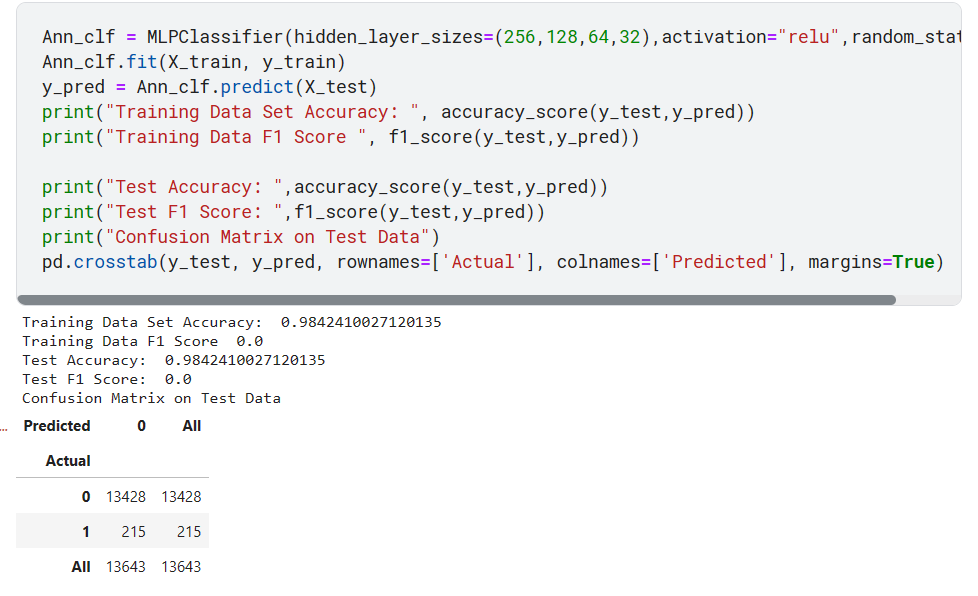

In [30]:
RFmodel = RandomForestClassifier()
RFmodel.fit(X_train, y_train)
  
# predict the mode
y_pred = RFmodel.predict(X_test)
  
# performance evaluatio metrics
print("Training Data Set Accuracy: ", accuracy_score(y_test,y_pred))
print("Training Data F1 Score ", f1_score(y_test,y_pred))

print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(classification_report(y_pred, y_test))

Training Data Set Accuracy:  0.9862233309751648
Training Data F1 Score  0.9862504645113341
Test Accuracy:  0.9862233309751648
Test F1 Score:  0.9862504645113341
Confusion Matrix on Test Data
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     13375
           1       0.99      0.98      0.99     13482

    accuracy                           0.99     26857
   macro avg       0.99      0.99      0.99     26857
weighted avg       0.99      0.99      0.99     26857



In [31]:
XGBmodel = XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide')
XGBmodel.fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = XGBmodel.predict(X_test)
print("Training Data Set Accuracy: ", accuracy_score(y_test,y_pred))
print("Training Data F1 Score ", f1_score(y_test,y_pred))

print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(classification_report(y_pred, y_test))


Training Data Set Accuracy:  0.9689094090926016
Training Data F1 Score  0.9686196399714383
Test Accuracy:  0.9689094090926016
Test F1 Score:  0.9686196399714383
Confusion Matrix on Test Data
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     13676
           1       0.96      0.98      0.97     13181

    accuracy                           0.97     26857
   macro avg       0.97      0.97      0.97     26857
weighted avg       0.97      0.97      0.97     26857



# **Hyperparameter Tuning**

In [32]:
hyperparameter_grid = {
    'n_estimators': [25, 50],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

In [33]:
#grid_search = GridSearchCV(RFmodel,param_grid=hyperparameter_grid)
#grid_search.fit(X_train, y_train)
#print(grid_search.best_estimator_)

# **Mini Pipeline Function**

In [34]:
def mini_pipeline(dataset, model):  
    dataset.columns = ['id', 'Product ID', 'Type', 'Air temperature',
       'Process temperature', 'Rotational speed', 'Torque',
       'Tool wear', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF']
    dataset['Product ID'].drop_duplicates()
    dataset.dropna()
    # Encode labels in column.     
    categorical_column=['Type']
    
    label_encoder = LabelEncoder()
   

    for k in categorical_column:
        for l in (dataset.columns):
            if k==l:
                dataset[f"{k}"]= label_encoder.fit_transform(dataset[f"{k}"])
            
                  
    id_list=list(dataset['id'])        
    X_pred=dataset.drop(columns=['id','Product ID'], axis=1)
    
    print(len(id_list))  
    #Model predictions
    Machine_Fail = model.predict(X_pred)
    print(len(Machine_Fail))

    #returns submission
    submission=pd.DataFrame(list(zip(id_list,Machine_Fail)),columns=['id','Machine failure'])
       

    print(submission.head())
    
    submission.to_csv("submission.csv", index=False) 
    

In [35]:
mini_pipeline(testing_set,RFmodel)

90954
90954
       id  Machine failure
0  136429                1
1  136430                0
2  136431                0
3  136432                0
4  136433                1
